In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import datetime as dt
import multiprocessing
import folium
import branca
import branca.colormap as cm
import pylab
import random as rd
import geopandas

from shapely.geometry import Point, Polygon, MultiPolygon
from tqdm.notebook import tqdm
from collections import Counter
from folium.plugins import HeatMap
from folium.features import DivIcon

# Single machine progress bar
from dask.diagnostics import ProgressBar

pd.options.display.precision = 2
#pd.set_option('display.max_columns', None)
nbRowsToDisplay = 250
pd.options.display.min_rows = nbRowsToDisplay
pd.options.display.max_rows = nbRowsToDisplay

/mnt/sdb1/gauthier/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Vectorized haversine function to calculate distances
#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [3]:
def plotHistogram(counts,labels,tit,xlab,ylab):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    counts=counts/np.sum(counts)
    ax.bar(labels, counts, align='center')
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)

In [4]:
fileDirectory = '/mnt/sdb1/gauthier/jupyter/'

# Prepare the dataset

## Add the attributes from the initial dataset to the modeled EV demands

In [10]:
#Load the results of the Monte Carlo simulation
nbIter=150000
df_results = pd.read_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'Iterations')

#Load the initial dataset
df = pd.read_pickle(fileDirectory+"data/DataModeling_Iteration4/tripStartEndPoints_Preparation2.pkl")
df = df.reset_index()

#Check that the 2 datasets are ordered exactly the same
print("Trips are ordered in the same way:",(df.gpsRecordedAtCETEnd==df_results.gpsRecordedAtCET_endTrip).all())

Trips are ordered in the same way: True


In [11]:
#Add attributes to the estimated demand dataset
df_results['carId']=df.carId
df_results['tripId']=df.tripId
df_results['minutesBeforeNextTrip']=df.minutesBetweenTrips.shift(-1)
df_results['lastTripFromCar']=df.newCarId.shift(-1).fillna(True)

#Assign 0 for the minutes before next trip for each last car
df_results['minutesBeforeNextTrip']=df_results.minutesBeforeNextTrip*~df_results.lastTripFromCar

#Compute the mean demand by location considering adjusting factor and percentage of electric cars
df_results['demand'] = df_results.sumDemand/nbIter

#Drop the unnecessary columns
df_results=df_results.drop(columns=['sumDemand','sumSquaredDemand','lastTripFromCar'])

#Save the results
#df_results.to_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'iterations_allData')

## Keep the points in Copenhagen

In [12]:
#Read the polygon of Copenhagen
copenhagenMap = geopandas.read_file(fileDirectory+"data/Simulation/Copenhagenmap.geojson")

#Create a new Copenhagen polygon by removing 360° to the longitude 
long, lat = copenhagenMap['geometry'][0].exterior.coords.xy
long = np.array(long) - 360 #Longitude is defined modulo 360 degrees 
copenhagenMap = Polygon(zip(list(long),list(lat)))

#Assign a boolean True to points that are in Copenhagen
%time df_results["isInCph"] = df_results.apply(lambda row: copenhagenMap.contains(\
    Point(row["endLongitude"], row["endLatitude"])), axis = 1)

#Keep the points in Copenhagen
df_subresults = df_results[df_results.isInCph==1].copy()

#Drop the unnecessary columns
df_subresults=df_subresults.drop(columns=['isInCph'])

print("% of removed points:", round((len(df_results) - len(df_subresults))/len(df_results)*100,2))

#Save the dataframe
#df_subresults.to_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'iterations_allDataInCph')

CPU times: user 1min 22s, sys: 404 ms, total: 1min 23s
Wall time: 1min 23s
% of removed points: 33.1


## Only select the data in September

In [13]:
df_Sept = df_subresults[df_subresults.gpsRecordedAtCET_endTrip < dt.datetime(2019,10,1)]

print("% of removed points:", round((len(df_results) - len(df_Sept))/len(df_results)*100,2))

#df_Sept.to_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'iterations_Sept')

% of removed points: 79.02


## Data in October

In [7]:
df_Oct = df_subresults[(df_subresults.gpsRecordedAtCET_endTrip > dt.datetime(2019,9,30)) &
                      (df_subresults.gpsRecordedAtCET_endTrip < dt.datetime(2019,11,1))]

print("% of removed points:", round((len(df_results) - len(df_Oct))/len(df_results)*100,2))

#df_Oct.to_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'iterations_Oct')

% of removed points: 76.11


## Data in November

In [8]:
df_Nov = df_subresults[(df_subresults.gpsRecordedAtCET_endTrip > dt.datetime(2019,10,31)) &
                      (df_subresults.gpsRecordedAtCET_endTrip < dt.datetime(2019,12,1))]

print("% of removed points:", round((len(df_results) - len(df_Nov))/len(df_results)*100,2))

#df_Nov.to_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'iterations_Nov')

% of removed points: 76.99


# Compute the demand by hour considering a 11kWh charge 

In [14]:
nbIter=150000
df = pd.read_pickle(fileDirectory+'data/Simulation/results_' + str(nbIter) + 'iterations_Sept')

#No adjusting factor, neither penetration rate is used 
#The demand corresponds to a 10% penetration rate in real life

#Compute the start and end charge assuming a power of 11kWh
minutesByHour = 60
df['startCharge'] = df['gpsRecordedAtCET_endTrip']
df['endCharge'] = df['startCharge'] + pd.to_timedelta(df.demand/11*minutesByHour,unit='m') 

#Calculate the energy to charge in each hour 
for hour in range(24):
    #When start date and end date are the same
    df['demandAt' + str(hour)] = (df.endCharge.dt.date==df.startCharge.dt.date)*\
        11/minutesByHour*(minutesByHour*((df.endCharge.dt.hour>hour)&(hour>df.startCharge.dt.hour))\
        +((df.endCharge-df.startCharge).dt.total_seconds()/60)*((df.endCharge.dt.hour==hour)&(hour==df.startCharge.dt.hour))\
        +(minutesByHour-(df.startCharge.dt.minute+df.startCharge.dt.second/60))*((df.endCharge.dt.hour>hour)&(hour==df.startCharge.dt.hour))\
        +(df.endCharge.dt.minute+df.endCharge.dt.second/60)*((df.endCharge.dt.hour==hour)&(hour>df.startCharge.dt.hour)))

    #When start date and end date differs
    #Add the demand for slots in the first day (the start day) and in the last day (the end day)
    df['demandAt' + str(hour)] += (df.endCharge.dt.date!=df.startCharge.dt.date)*\
        11/minutesByHour*(minutesByHour*(hour>df.startCharge.dt.hour)+ #Demand for the time slots after start date
        minutesByHour*(hour<df.endCharge.dt.hour)+ #Demand for the time slots before end date
        (minutesByHour-(df.startCharge.dt.minute+df.startCharge.dt.second/60))*(hour==df.startCharge.dt.hour)\
        +(df.endCharge.dt.minute+df.endCharge.dt.second/60)*(df.endCharge.dt.hour==hour))

    #Add the demand for the slots in days between start and end days 
    df['demandAt' + str(hour)] += (df.endCharge.dt.date != df.startCharge.dt.date) * 11 *\
        ((df.endCharge.dt.date - df.startCharge.dt.date).dt.days-1)

#df.to_pickle(fileDirectory+'data/Simulation/demandByHour_' + str(nbIter) + 'iterations_Sept_penetrationRate=10%')

# Compute the distance to the charging stations

In [42]:
df_chargingStations=pd.read_pickle(fileDirectory+'data/Simulation/chargingStations_supply')

#For each end trip, get the distance from the charging stations

#Get the distance from all charging stations
for chargingStationNumero in range(1,len(df_chargingStations)+1): 
    chargingStationLat=np.full(
      shape=len(df),
      fill_value=df_chargingStations.loc[chargingStationNumero,:].latitude,
      dtype=np.float
    )
    chargingStationLong=np.full(
      shape=len(df),
      fill_value=df_chargingStations.loc[chargingStationNumero,:].longitude,
      dtype=np.float
    )
    
    #Get the distance from the charging station 
    df['distanceInKmFromCS'+str(chargingStationNumero)]= haversine(
        df.endLatitude, df.endLongitude, chargingStationLat, chargingStationLong, 
                  to_radians=True, earth_radius=6371)

#df.to_pickle(fileDirectory+'data/Simulation/DistanceFromCSAndDemandByHour_150000iterations_Sept_penetrationRate=10%')

# Parse the data of the energy supply

## First "naive" approach

In [ ]:
#Number of outlets by location 
outletsByLocation_str = "3 5 7 4 4 6 6 4 3 4 2 8 4 2 2 6 6 6 4 2 6 6 8 4 6 4 4 6 4 3 6 4 4 2 4 8 2 6 4 2 4 8 4 4 2 4 4 4 6 6 2 6 2 4 6 2 2 6 2 2 3 2 4 2 4 4 4 12 4 4 4 6 6 2 6 4 3 43 4 5 8 2 4 2 2 4 4 8 6 6 4 4 6 6 4 6 4 4 3 6"
outletsByLocation =  [int(s) for s in outletsByLocation_str.split() if s.isdigit()]
print("Mean number of outlets by location: ",np.mean(outletsByLocation))

In [ ]:
#Define the input parameters
nbDays=len(df.gpsRecordedAtCET_endTrip.dt.date.unique())
nbHoursByDay = 24
utilisationPercentage=0.09

In [ ]:
#Get the power provided by the public charging stations
chargingStationsPower= np.array([3.7 ,11,22,24,43,50])
nbChargingStationsByPower = np.array([2,148,30,1,11,30])
nbStations = np.sum(nbChargingStationsByPower)

nbChargingOutletsByChargingStation_11kW_str = "1 6 4 6 4 4 6 6 4 2 4 4 2 6 8 2 2 2 4 4 6 6 2 4 4 6 6 6 8 4 6 4 4 4 12 4 4 4 6 4 4 2 6 2 8 4 4 6 2 4 6 4 6 6 4 4 6 6 4 4 4 4 6 6 4 4 4 8 4 4 4 6 2 2 6 4 2 6 6 2 4 6 4 6 6 6 6 4 4 4 4 4 2 2 4 4 2 2 2 4 2 4 6 4 2 4 4 4 6 4 4 6 4 6 2 6 2 2 4"
nbChargingOutletsByChargingStation_11kW = [int(s) for s in nbChargingOutletsByChargingStation_11kW_str.split() if s.isdigit()]
print("Mean number of outlets by location for 11kW charging stations: ",np.mean(nbChargingOutletsByChargingStation_11kW))

nbChargingOutletsByChargingStation_22kW_str = "2 4 4 2 2 2 4 1 12 4 2 4 6 4 4 8 8 8 16 8 4 2 8 2 2 2 4 2 1 1 2 12"
nbChargingOutletsByChargingStation_22kW = [int(s) for s in nbChargingOutletsByChargingStation_22kW_str.split() if s.isdigit()]
print("Mean number of outlets by location for 22kW charging stations: ",np.mean(nbChargingOutletsByChargingStation_22kW))

avgOutletNbByChargingPower = np.array([3, np.mean(nbChargingOutletsByChargingStation_11kW),
        np.mean(nbChargingOutletsByChargingStation_22kW),1,1,1])

print("Nb outlets: ",np.sum(nbChargingStationsByPower*avgOutletNbByChargingPower))

print(" ")
print("Power provided by outlet power and by hour considering a full utilisation (7/7, 24/24): ")
for i in range(len(chargingStationsPower)):
    print("   For outlet of",chargingStationsPower[i],"kWh:",
          int(chargingStationsPower[i]*nbChargingStationsByPower[i]*avgOutletNbByChargingPower[i]))
print("Total power provided by hour considering a full utilisation (7/7, 24/24): ",
      int(np.sum(chargingStationsPower*nbChargingStationsByPower*avgOutletNbByChargingPower)))

print(" ")
print('Total power supply in Cph for',str(nbDays),'days:' , np.sum(chargingStationsPower*nbChargingStationsByPower\
                    *avgOutletNbByChargingPower)*nbHoursByDay*nbDays)

## Parse data to know the charging power and outlet number by charging station using xpath

In [ ]:
#Def a function to check if a string contains a number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [ ]:
#Get the HTML code and build a tree from it
URL = 'https://www.uppladdning.nu/List.aspx#DK'
page=requests.get(URL)
tree = html.fromstring(page.content)

#Define the necessary parameters to parse the data
cphAreas = ['Frederiksberg','Frederiksberg (Kbh K)','Frederiksberg C','København','København K','København N',
           'København NV','København ø','København Ø','København S','København sv','København SV','København V']
powerWhenUndefinedPower = 11
chargingStationName = []
nbOutlets = []
powerOutlets = []
areaName = []
latitude = []
longitude = []

#From www.uppladdning.nu, parse the name, latitude, longitude, power and outlet number for each station

#For all areas in Cph
for area in cphAreas:
    #Get the id for the charging station
    endURL = tree.xpath('//*[@id="' +'DK-' + area +  '"]/../ul/li/a/@href')
    
    #Get the name of the charging stations and its area
    chargingStationName += tree.xpath('//*[@id="' +'DK-' + area +  '"]/../ul/li/a/text()')
    areaName += [area for i in range(len(endURL))]
    
    #For each charging station in the area
    for url in endURL:
        
        #Get the HTML code and build a tree from it
        page_charger=requests.get('https://www.uppladdning.nu/' + url)
        tree_charger = html.fromstring(page_charger.content)
        
        #Get the number of chargers and the power of them for each charging stations
        nbOutlets_it = tree_charger.xpath('//*[@id="div2"]/ul/li/a/strong/text()')
        powerOutlets_it = tree_charger.xpath('//*[@id="div2"]/ul/li/a/big/strong/text()')

        #Keep only the number of outlets 
        nbOutlets_it = [float(el) for string in nbOutlets_it for el in string.split() if is_number(el)]

        #Keep only the power of the outlet
        powerOutlets_it = [float(el) for string in powerOutlets_it for el in string.split() if is_number(el)]
        
        #Assign a power if the power is not assigned for one charging station
        if len(nbOutlets_it)>len(powerOutlets_it):
            powerOutlets_it.append(powerWhenUndefinedPower)
            
        #Get the latitudes and longitudes
        latitude_it = tree_charger.xpath('//*[@id="details"]/span[14]/text()')
        longitude_it = tree_charger.xpath('//*[@id="details"]/span[15]/text()')
        
        #Store the results
        nbOutlets.append(nbOutlets_it)
        powerOutlets.append(powerOutlets_it)
        latitude += latitude_it
        longitude += longitude_it

In [ ]:
#Remove part in square bracket in the charging station names and latitudes, longitudes
chargingStationName = [re.sub(r'\s\[[^\]]*\]', r'', name) for name in chargingStationName]
latitude = [float(re.sub(r'\s\[[^\]]*\]', r'', lat)) for lat in latitude]
longitude = [float(re.sub(r'\s\[[^\]]*\]', r'', long)) for long in longitude]

#Store the results in a dataframe
df_chargingStations = pd.DataFrame({'areaName':areaName,'name':chargingStationName,'latitude':latitude,
                                    'longitude':longitude,'nbOutlets':nbOutlets,'powerOutlets':powerOutlets})

In [ ]:
#df_chargingStations.to_pickle(fileDirectory+"data/Simulation/chargingStations")

In [ ]:
#Check that each charging stations has the same number of outlets and 
#corresponding power
#df_chargingStations.nbOutlets.apply(lambda row: len(row))==\
#df_chargingStations.powerOutlets.apply(lambda row: len(row))

# Calculate the energy supply

In [21]:
df_chargingStations = pd.read_pickle(fileDirectory+"data/Simulation/chargingStations")

### Only keep the data in the inner center of Copenhagen

In [22]:
"""#Only keep the data in the inner center (without residential areas)

nbRowsBeforeFiltering = len(df_chargingStations)

#Read the polygon of Copenhagen
innerCenterCopenhagen = geopandas.read_file("data/Simulation/InnerCenterCopenhagen_modified.geojson")

#Create a new Copenhagen polygon by removing 360° to the longitude 
long, lat = innerCenterCopenhagen['geometry'][0].exterior.coords.xy
innerCenterCopenhagen = Polygon(zip(list(long),list(lat)))

#Assign a boolean True to points that are in Copenhagen
%time df_chargingStations["isInPolygon"] = df_chargingStations.apply(lambda row: innerCenterCopenhagen.contains(\
    Point(row["longitude"], row["latitude"])), axis = 1)

#Keep the points in Copenhagen
df_chargingStations = df_chargingStations[df_chargingStations.isInPolygon==1]
df_chargingStations=df_chargingStations.drop(columns='isInPolygon')

print("% of kept charging stations:",np.floor(100*len(df_chargingStations)/nbRowsBeforeFiltering))"""

'#Only keep the data in the inner center (without residential areas)\n\nnbRowsBeforeFiltering = len(df_chargingStations)\n\n#Read the polygon of Copenhagen\ninnerCenterCopenhagen = geopandas.read_file("data/Simulation/InnerCenterCopenhagen_modified.geojson")\n\n#Create a new Copenhagen polygon by removing 360° to the longitude \nlong, lat = innerCenterCopenhagen[\'geometry\'][0].exterior.coords.xy\ninnerCenterCopenhagen = Polygon(zip(list(long),list(lat)))\n\n#Assign a boolean True to points that are in Copenhagen\n%time df_chargingStations["isInPolygon"] = df_chargingStations.apply(lambda row: innerCenterCopenhagen.contains(    Point(row["longitude"], row["latitude"])), axis = 1)\n\n#Keep the points in Copenhagen\ndf_chargingStations = df_chargingStations[df_chargingStations.isInPolygon==1]\ndf_chargingStations=df_chargingStations.drop(columns=\'isInPolygon\')\n\nprint("% of kept charging stations:",np.floor(100*len(df_chargingStations)/nbRowsBeforeFiltering))'

### Compute the supply by charging station

In [23]:
#Remove the second 50kWh outlet for 50kWh charging station as only one 50kWh outlet can be used by cs
for index, row in df_chargingStations.iterrows():
    if 50 in row.powerOutlets:
        row.nbOutlets.remove(1)
        row.powerOutlets.remove(50)

#Replace the charging stations of 22kWh by 11kWh as they cannot be used so far
#power=22
#df_chargingStations['powerOutlets']=df_chargingStations.apply(lambda row: 
#        [11 if p==22 else p for p in row.powerOutlets] ,axis=1)

#Create new columns for each charging power and for the number of associated chargers
outletPower = [3.7, 6, 11, 22, 24, 43, 50]
df_chargingStations['supplyByHour'] = 0

for i in range(len(outletPower)):
    power = outletPower[i]
    df_chargingStations[str(power) + 'kWhOutletNb'] = df_chargingStations.apply(lambda row: 
        row.nbOutlets[row.powerOutlets.index(power)] if power in row.powerOutlets else None,axis=1)
    
    df_chargingStations['supplyByHour'] = df_chargingStations.supplyByHour.add(
        power * df_chargingStations[str(power) + 'kWhOutletNb'] , fill_value=0)
    
#The charging stations of power 50kW don't have to be multiplied by 2 as there are only one outlet 
#including 2 different types of chargers 

In [24]:
#Calculate the supply by charging station
#Define the input parameters
nbDays=30
nbHoursByDay = 24
df_chargingStations['supplyByMonth']=df_chargingStations.supplyByHour*nbDays*nbHoursByDay #Supply for the whole time period
df_chargingStations['supplyByMonthForOneHour']=df_chargingStations.supplyByHour*nbDays #Supply for the whole time period

#Assume that only 70% of the supply can be used as a lot of cars can only use 7kW from 11kW and 22kW charging stations 
#df_chargingStations['supplyByMonth'] = df_chargingStations.supplyByMonth #* 0.7
#df_chargingStations['supplyByHour'] = df_chargingStations.supplyByHour #* 0.7

#Drop the charging stations with no supply
df_chargingStations=df_chargingStations[df_chargingStations.supplyByMonth>0]
df_chargingStations=df_chargingStations.reset_index(drop=True)

#Add 1 to the index of the charging stations as chargings stations index start now at 1
df_chargingStations.index=df_chargingStations.index+1

# Store the results

In [25]:
#df_chargingStations.to_pickle(fileDirectory+"data/Simulation/chargingStations_supply")

# Check that results make sense

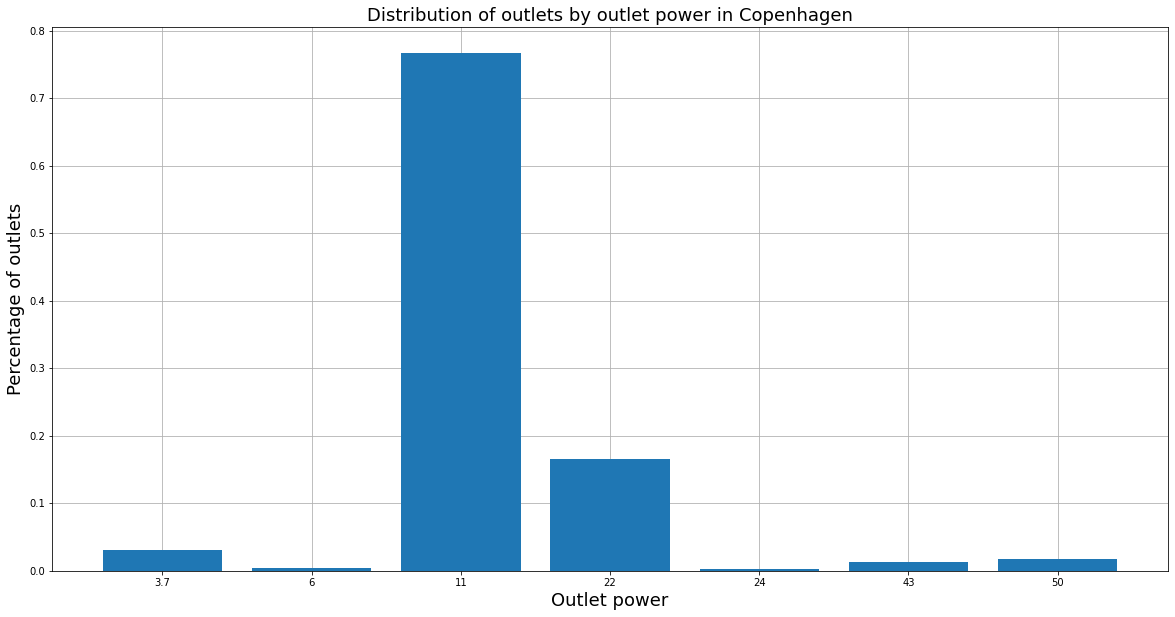

In [26]:
#df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")

outletPower = [3.7, 6, 11, 22, 24, 43, 50]

#df_chargingStations = df_chargingStations.iloc[:,:14]
outletNbNames=[str(power)+'kWhOutletNb' for power in outletPower]
CSNbByChargerType = df_chargingStations[outletNbNames].sum() #* outletPower

plotHistogram(CSNbByChargerType.values,[str(power) for power in outletPower],
              'Distribution of outlet power in Copenhagen','Outlet power',
             'Percentage of outlets')

In [27]:
print("% of energy provided by each outlet type:")
np.floor(CSNbByChargerType / CSNbByChargerType.sum() *100)

% of energy provided by each outlet type:


3.7kWhOutletNb     3.0
6kWhOutletNb       0.0
11kWhOutletNb     76.0
22kWhOutletNb     16.0
24kWhOutletNb      0.0
43kWhOutletNb      1.0
50kWhOutletNb      1.0
dtype: float64

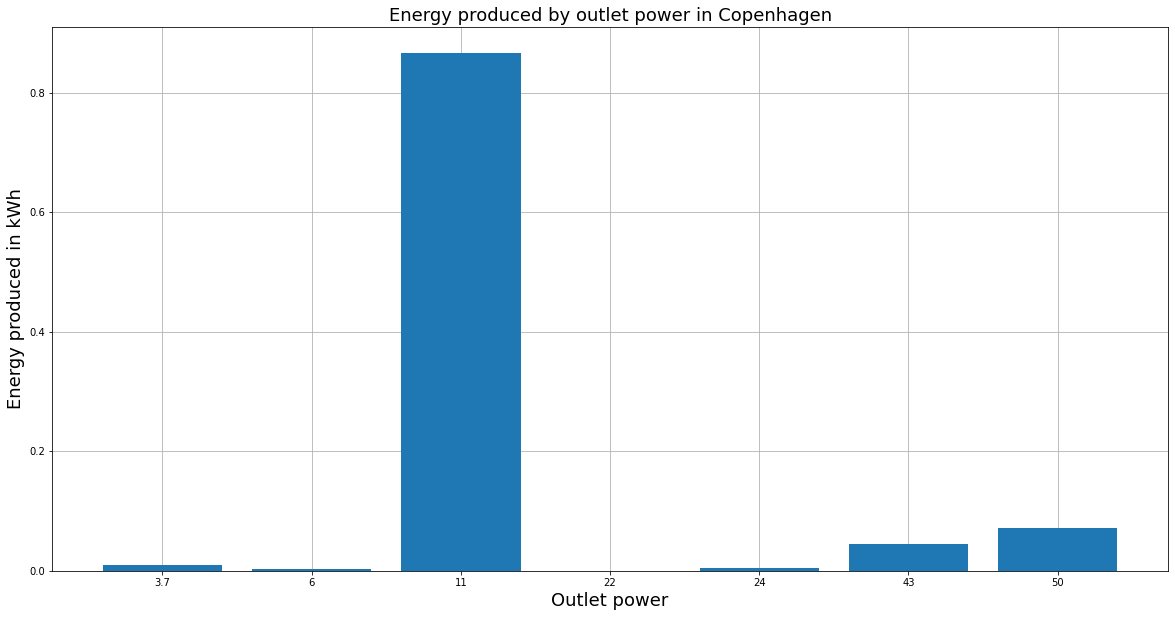

In [8]:
#Have a look at the same when the outlet of 22kWh are replaced by 11kWh outlets
df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")

outletPower = [3.7, 6, 11, 22, 24, 43, 50]

#df_chargingStations = df_chargingStations.iloc[:,:14]
outletNbNames=[str(power)+'kWhOutletNb' for power in outletPower]
energyProducedByChargerType = df_chargingStations[outletNbNames].sum() * outletPower

plotHistogram(energyProducedByChargerType.values,[str(power) for power in outletPower],
              'Energy produced by outlet power in Copenhagen','Outlet power',
             'Energy produced in kWh')

In [7]:
print("% of energy provided by each outlet type:")
np.floor(energyProducedByChargerType / energyProducedByChargerType.sum() *100)

% of energy provided by each outlet type:


3.7kWhOutletNb     0.0
6kWhOutletNb       0.0
11kWhOutletNb     86.0
22kWhOutletNb      0.0
24kWhOutletNb      0.0
43kWhOutletNb      4.0
50kWhOutletNb      7.0
dtype: float64

86% of the energy is poduced by 11kWh charging stations. (Remember that 22kWh outlets are considered 11kWh outlets as cars can only use 11kWh with AC)
Then 7% of the energy is produced by 50kWh outlets.

It makes sense as 5/6 of the charging stations are normal charging stations (below 22kWh) and 1/6 corresponds to fast charging stations.

In [52]:
#Check if the supply by hour corresponds to the power of outlets and number of outlets
#It is worth noticing that only 70% of the total supply can be used
df_chargingStations[['areaName','name','latitude','longitude','nbOutlets','powerOutlets','supplyByHour']].head()

,areaName,name,latitude,longitude,nbOutlets,powerOutlets,supplyByHour
1,Frederiksberg,Frederiksberg Rådhus,55.68,12.53,[2.0],[11.0],22
2,Frederiksberg,Frederiksberg Brandstation,55.68,12.53,[2.0],[11.0],22
3,Frederiksberg,Frederiksberg Hospital,55.69,12.53,"[1.0, 1.0, 1.0]","[50.0, 50.0, 43.0]",93
4,Frederiksberg,Flintholm alle - Frederiksberg,55.68,12.50,[4.0],[11.0],44
5,Frederiksberg,Thurøvej - Frederiksberg,55.68,12.52,[4.0],[11.0],44


In [53]:
#Check that the total demand is equal to the sum of demand by hour
totalDemand=0
for hour in range(24):
    totalDemand+= df['demandAt'+str(hour)].sum()
    
print('Total demand:',df.demand.sum())
print('Total demand as the sum of the demand by hour:',totalDemand)

Total demand: 1035097.2486765623
Total demand as the sum of the demand by hour: 1034990.3461868422
